# Import FRETclass package

This imports the pySensor module and sets the default plotting parameters for matplotlib

In [74]:
import pySensor
import os
from pylab import *
import pandas as pd
import matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
#default plotting parameters
params = {'legend.fontsize': 15,
          'figure.figsize': (15, 8),
         'axes.labelsize': 20,
         'axes.titlesize': 25,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'lines.linewidth':2}
matplotlib.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# User Inputs

In [79]:
Experiment_Name='Cytoplasm_mGlu'
Calib_File_Name='CalibrationFiles/Calibration_xlsx/Calib_CFP_YFP_405-458_5-31-2018.xlsx'
Interpolation=[500,500]
Register_to_Ex1=False
Central_Tendency='median'
Export_Data=[]

# Import Calibration File

In [30]:
calib=pd.read_excel(Calib_File_Name)


# Initialize FRET Object


In [31]:
Data=pySensor.FRET_Calc(Experiment_Name,calib)


In [80]:
X=pySensor.FRET_Calc('Test',calib)

In [81]:
X.import_xlsx('Data_Archive/Calcium_Sensors_noAF_6-8-2018.xlsx',observation=['group','image','region'])

KeyError: 'Calibration_Name'

The following cell plots the normalized emission shapes and calibration parameters so that you can check that the appropriate calibration information is input

Donor Quantum Yield: 0.4
Acceptor Quantum Yield: 0.6
Gamma Parameter: 0.113669775716
eD/eA 405nm: 57.2982608387
eD/eA 458nm: 6.51308045844


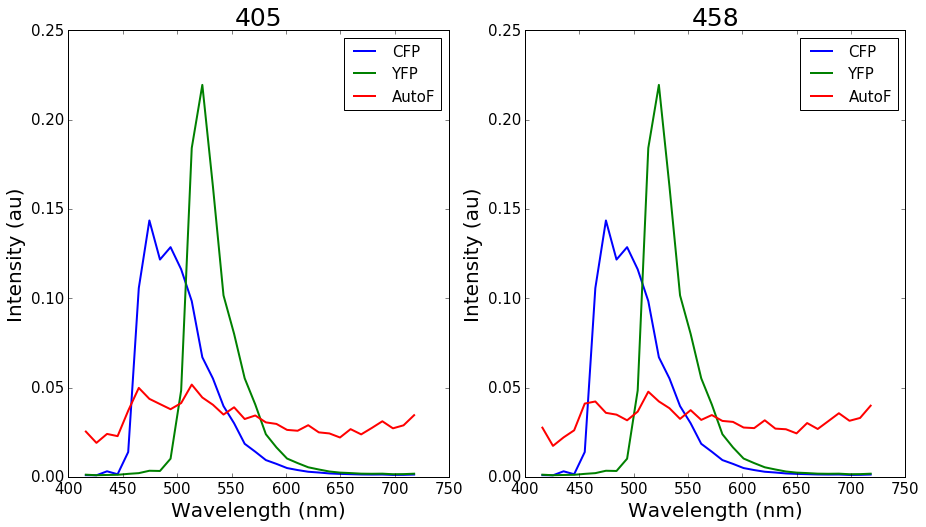

In [32]:
comps,(ax1,ax2)=subplots(1,2)
ax1.set_title(Data.ex_names[0])
ax1.plot(Data.wl_em,Data.comps1.T)
ax1.legend([Data.fluor_names[0],Data.fluor_names[1],'AutoF'])
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Intensity (au)')
ax2.set_title(Data.ex_names[1])
ax2.plot(Data.wl_em,Data.comps2.T)
ax2.legend([Data.fluor_names[0],Data.fluor_names[1],'AutoF'])
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Intensity (au)')
print('Donor Quantum Yield: '+str(Data.Qd))
print('Acceptor Quantum Yield: '+str(Data.Qa))
print('Gamma Parameter: '+str(Data.gamma))
print('eD/eA '+Data.ex_names[0]+'nm: '+str(Data.ex_ratio1))
print('eD/eA '+Data.ex_names[1]+'nm: '+str(Data.ex_ratio2))

## Read Image Names from Grouped_Tiffs directory

The following cell recursively reads directories in 'Grouped Tiffs' folder to get all the image filenames for importing
            
Directories must be structured as such:
            
> Grouped Tiffs
>> Experimental Group A
>>> Frequency 1
>>>> F1 tifs (multi channel spectral images)

>>> Frequency 2
>>>> F2 tifs (multi channel spectral images)

>>> Masks
>>>> Mask tifs (single channel binary images)


>> Experimental Group B...

Keyword Arguments:
> 'print_names=True' prints the names of all images for you to check

In [33]:
Data.get_nested_subdirectories(print_names=True)

Cytoplasm_mGlu2-DOX-405-06.tif
Cytoplasm_mGlu2-DOX-458-06.tif
Cytoplasm_mGlu2-DOX-405-06-.tif


# Create numpy image array

The following cell then generates a numpy array from the image data 

Keyword Arguments:
> 'interpolation=[x_res,y_res]' resizes all of the image data to the input resolution using bilinear interpolation. False defaults to the native image resolution (assumes all images are the same size)
>> By downsampling the image to a smaller image size the spectral noise at the pixel level can be reduced at the cost of spacial resolution

In [34]:
Data.get_tif_container(interpolation=Interpolation)

# Check that Masks Align

The following cell plots a binary mask images over the intensity image to ensure they align

(<matplotlib.image.AxesImage at 0x12c2e2e10>,
 <matplotlib.colorbar.Colorbar at 0x152a9d750>)

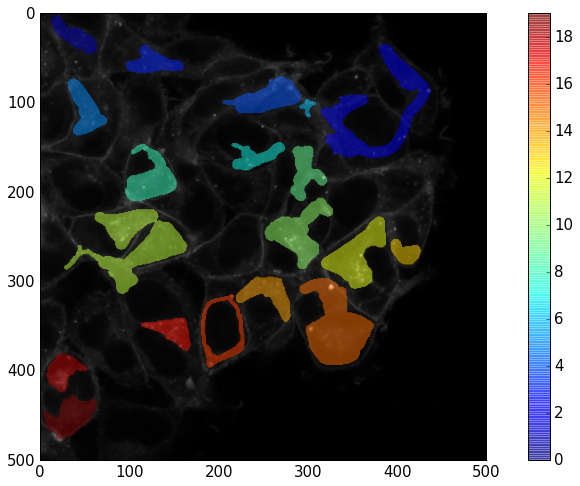

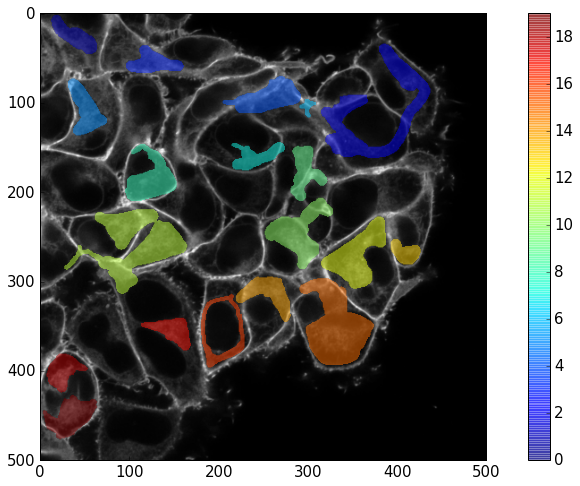

In [35]:
g=0 #selects which group
i=-1 #selects which image

ex=1
image=np.mean(Data.tif_array[g][ex-1][i,:,:,:],axis=0)
mask=Data.tif_array[g][2][i,:,:]
mask[mask==0]=np.nan
imshow(image,cmap="Greys_r")
imshow(mask,alpha=.5,vmin=0),colorbar()
figure()
ex=2
image=np.mean(Data.tif_array[g][ex-1][i,:,:,:],axis=0)
mask=Data.tif_array[g][2][i,:,:]
mask[mask==0]=np.nan
imshow(image,cmap="Greys_r")
imshow(mask,alpha=.5,vmin=0),colorbar()

## Register ex1 and ex2 images

Registers the images from the two excitation frequencies in the x and y dimensions in order to account for any lateral drift between aquiring the two images

Keyword Arguments:

> 'to_F1=bool' option registers frequency 2 image to the frequency 1 image as opposed to registering frequency 1 to frequency 2 (default). The stationary imaged should be whichever frequency the mask was created from.

> 'print_shift=bool' options allows the translation vector for each image to be printed, any large shifts (>5%) could be the registration algorithm failing or the images being read in incorrectly

In [36]:
Data.register_images(to_F1=Register_to_Ex1)


('Y: 0.000', 'X: 0.000')
_____________



## Sort Image Data

The following cell sorts and averages masked pixels into DataFrames according to each observation type (pixel, region [contiguous masked area], image or group). Each observation is labeled with its cooresponding group, image, region, x location, y location and pixel area. Since the masked regions are typically small compared to the whole image this greatly reduces the file size and memory usage because all of the pixels outside of the mask dont need to be saved.
according to observation type 

Keyword Arguments:
> central_tendency='median' or 'mean' this parameter chooses either the mean or the median to find the average spectra as well as the default variance measurement (standard deviation [SD] for the mean and median average deviation [MAD] for the median).
>> The median is more appropriate as long as the number of observations is reasonably large. This is because the FRET is computed using a ratio of donor and acceptor magnitudes. If the donor and acceptor magnitudes are normally distributed the FRET will follow a Cauchy distribution, which has no stable mean.

In [37]:
Data.sort_tif_container(central_tendency=Central_Tendency)
Data.group_DF.T


Total Pixels: 37286
Total Regions: 19
Total Images: 1
Total Groups: 1



,0
label,Cytoplasm
area,37286
group,0
image,1
region,19
spectra1,"[186.63658905, 229.091743469, 289.155593872, 1..."
spectra2,"[146.775978088, 89.2240333557, 106.816932678, ..."
x_loc,259
y_loc,248


# Unmix spectra for each observation

The following cell cycles through a DataFrame and unmixes the spectra into different fitting components, the magnitudes of which are then saved into the DataFrame along with a few other parameters such as the integrated intensity, residual and maxima.

Keyword Arguments:
> observation='all' option unmixes all dataframes or a list of observations
types can be specified, for example: observation=["group","image",region]  

In [38]:
Data.unmix_DF(observation='all')
Data.group_DF.T


,0
label,Cytoplasm
area,37286
group,0
image,1
region,19
spectra1,"[186.63658905, 229.091743469, 289.155593872, 1..."
spectra2,"[146.775978088, 89.2240333557, 106.816932678, ..."
x_loc,259
y_loc,248
D1,6256.77


# FRET Calculations

The following cell uses the unmixed magnitudes to caculate the FRET efficiency as well as intermediate parameters such as alpha, beta, and the acceptor direct excitation magnitudes.

In [39]:
Data.default_calculations()
Data.group_DF.T


,0
label,Cytoplasm
area,37286
group,0
image,1
region,19
spectra1,"[186.63658905, 229.091743469, 289.155593872, 1..."
spectra2,"[146.775978088, 89.2240333557, 106.816932678, ..."
x_loc,259
y_loc,248
D1,6256.77


# User Defined Parameters

The following cell allows new parameters to be defined using simple functions ( +, -, /, *, and ^). It is commented out by default but can be used if needed.

Keyword Arguments:
>calc=[param1,operator,param2]
>>For example the normalized Donor Magnitude at frequency 1 can be calculated by using a calculation input of ['D1','/','I1']

>name=string used for calling the new parameter. 
>> False defaults to concatenating the calc entries (D1/I1 for the above example)

In [40]:
#Data.new_calculation(['D1','/','I1'],name='D1norm')

# Plotting Functions

These functions display various graphs which help interpret the data. 

Many are flexible with respect to what is considered an observation (ie. a single pixel, the average from a contiguous masked area (region), the average of an entire image, or the average of all images in an experimental group).

Many are also flexible with respect to what parameters are plotted. The available parameters are dictated by the indicies of the dataframes printed above. Below is a description of each

Parameter options:
>'D' - Magnitude of the Donor Component of the raw spectra (since each fitting component is normalized to unit area, these magnitudes in terms of area)

>'A' - Magnitude of the Acceptor Component of the raw spectra

>'AF' - Magnitude of the Auto Fluorescence Component of the raw spectra

>'I' - The spectra Intensity (ie. total integrated area of the raw spectra)

>'R' - The residual area unable to be accounted for with the fitted components normalized by the intensity. (provides a relative measure of the noise, ie. noiser spectra have larger residuals)

>'Mx' - Spectra Maximum (useful for determining if any pixels are saturated)

>'Ind' - FRET index (a simple ratio of A/D, a widely used relative measure of FRET, but does not account for the acceptor direct excitation or differences in stoicheometry)

>'Alpha' - An intermediate calculated value for determining the FRET efficiency (D2/D1)

>'Beta' - Another intermediate calculated value for determining the FRET efficiency (A2-Alpha*A1)

>'A_dir' - The Magnitude of the acceptor which is due to direct excitation (not transfered from the donor due to FRET)

>'Eff' - The FRET Efficiency, the proportion of energy (between 0-1) that is transfered from the donor to the acceptor (the FRET on a per donor fluorophore basis)

>'eD_eA' - The ratio of molar extinction coefficients at a given frequency (eD/eA). 

>'S' - The ratio of Donor fluorophores to Acceptor fluorophores (this calculation is dependent on the tandem sample used to create the calibration being perfectly 1:1)

>'Eff_S' - The FRET Efficiency corrected for unpaired donor fluorophores (the FRET on a per acceptor basis). As this is dependent on the measured stoicheometry, the tandem sample used in the calibration must be 1:1.

>'group' - The ID number of the group that contains the observation.

>'image' - For group observations, this is the number of images in the group. For image, region, and pixel observations this number is the ID number of the image that contains this observation.

>'region' - For group and image observations, this is the number of regions in the group or image. For region, and pixel observations, this number is the ID number of the region that contains this observation.

>'area' - The number of pixels which are averaged together to form an observation.

>'x_loc' - The X position of an observation in its image (only meaningful for pixel and region observations)

>'y_loc' - The Y position of an observation in its image (only meaningful for pixel and region observations)

### Spectral Variance
This function plots 3 panels: the first shows the mean normalized spectra shape and +/- 1 MAD or SD denoted by the shaded region, the second shows the standard deviation of the spectra plotted vs the square root of the intensity (linearity of this plot denotes purely Poissonian noise), and the third shows the slope of the SD vs I^1/2 plot for each point as a function of the emission wavelength (points which do not follow a horizontal line indicate which frequencies show non-Poissonian noise).

Keyword Arguments
> ex=1 or 2: tells the function which excitation frequency to plot

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

> colors=list of colors to plot with. A blank list uses the default color list.

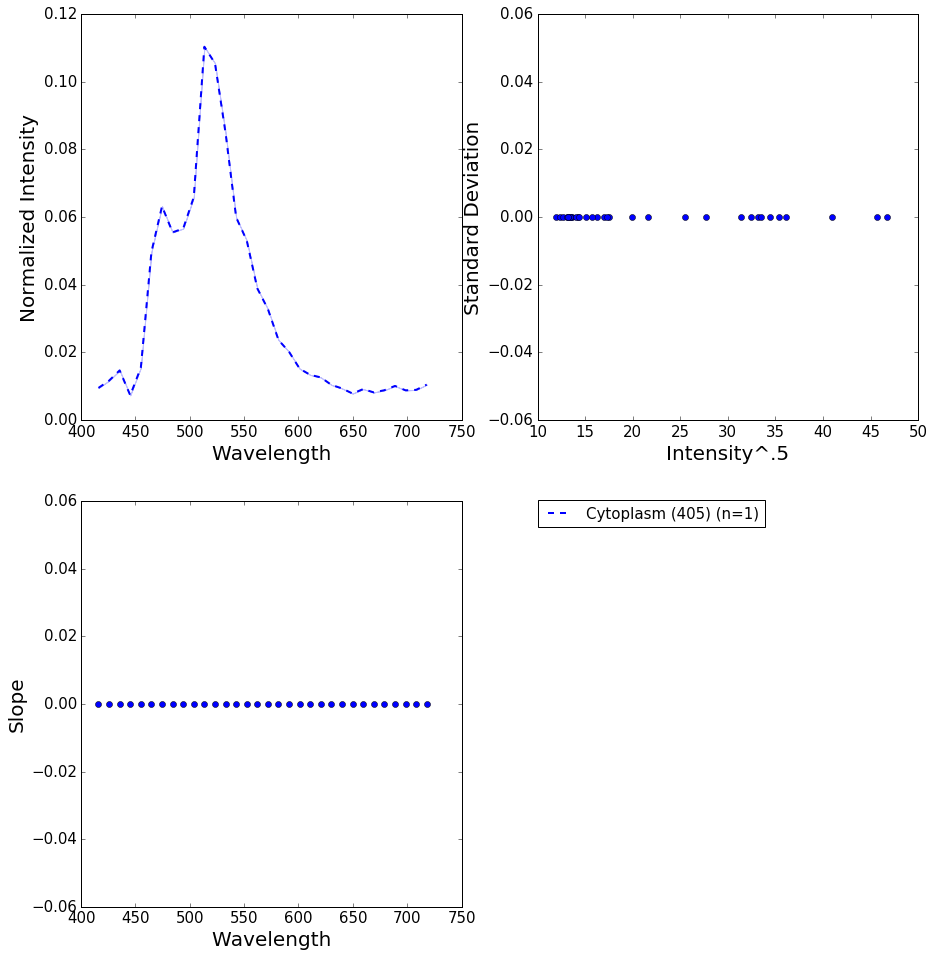

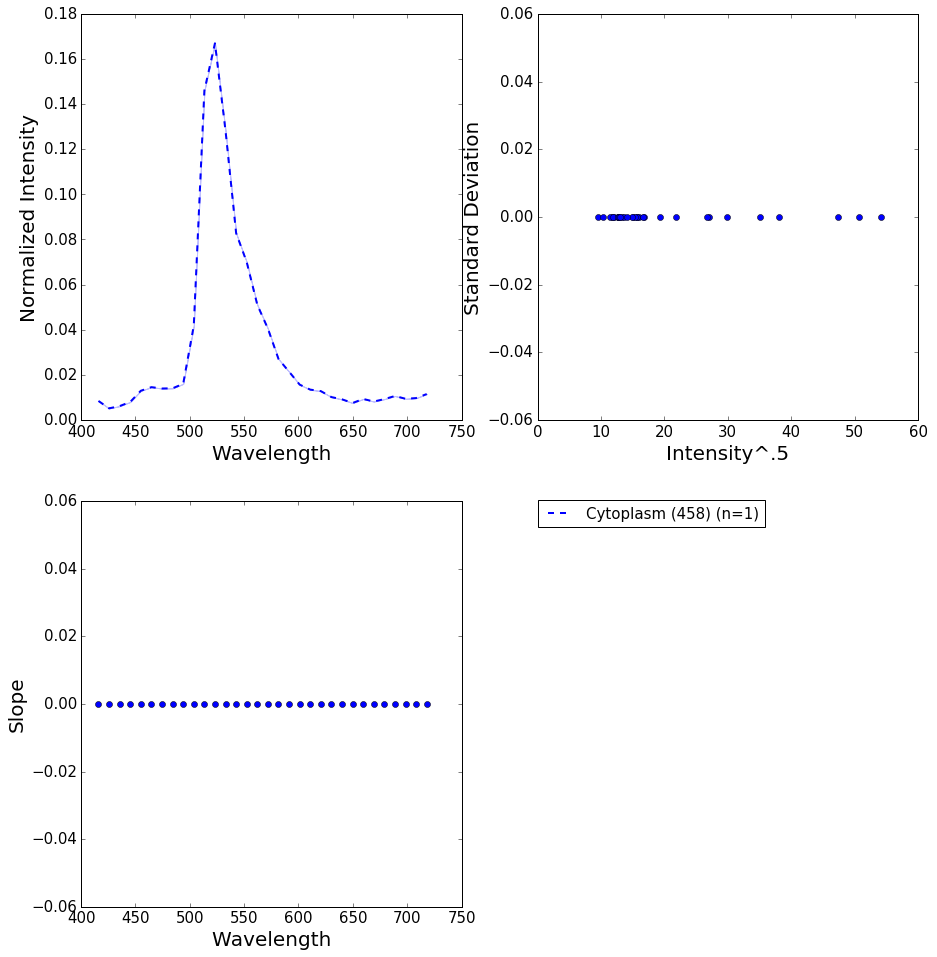

In [41]:
Data.spectraVariance(ex=1,observation='image',plot_by='group',
                        specify=[],colors=[])

Data.spectraVariance(ex=2,observation='image',plot_by='group',
                        specify=[],colors=[])

### Spectra Fit
This function plots 2 panels showing the average (mean or median depending on central tendency option chosen) normalized spectra along with their unmixed components (all +/-1 MAD or SD) to ensure the linear unmixing is reasonable for each excitation frequency. The average and variance of the normalized spectra (rather than the raw spectra) is more telling 

Keyword Arguments
> norm=boolean: controls whether the average and variance of the normalized (True) or raw (False) spectra are plotted
>> the normalized spectra are more telling, as the FRET efficiency is related only to the shape of the spectra and therefore the variablitity due to the changing magnitude of the spectra is not important to the FRET calculation

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

Getting Figure Sets
---------------------------------------------------------------------------------

Generating Plots
---------------------------------------------------------------------------------



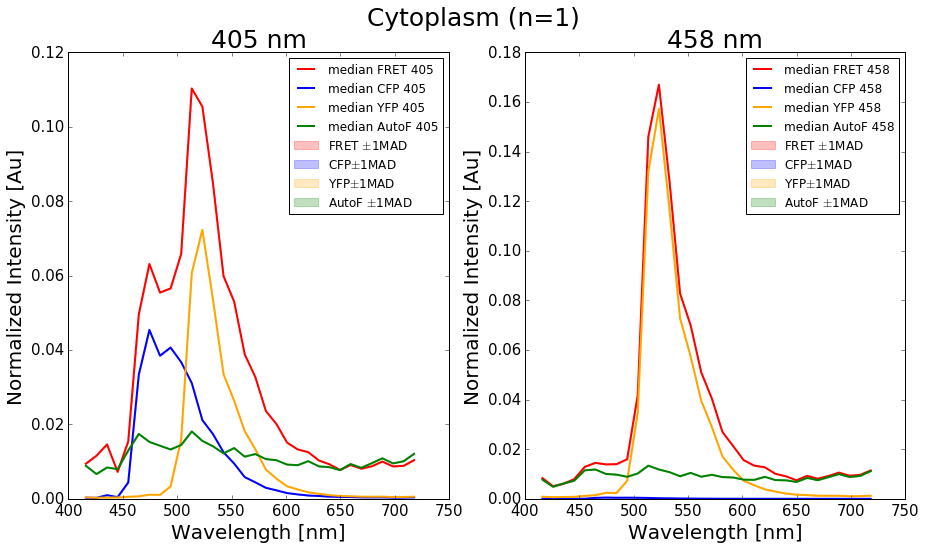

In [42]:
Data.spectraFit(norm=True,observation='image',plot_by='group',specify=[])

### FRET Variance
This function plots 4 panels showing the calculation steps for determining the FRET efficiency. The first panel shows the donor fits used to determine the alpha parameter (raw spectra already have AutoF removed). The second panel shows the calculation of the beta parameter and compares its shape to the acceptor component. The third panel shows the raw spectra at both frequencies corrected for the acceptor direct excitation (using beta and the gamma calibration parameter). The fourth panel shows the corrected spectra unmixed into donor and acceptor components which are used to calculate the FRET efficiency. The variance in each of these spectra is denoted with shaded regions showing +/- 1 MAD or SD.

Keyword Arguments
> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

Getting Figure Sets
---------------------------------------------------------------------------------

Generating Plots
---------------------------------------------------------------------------------



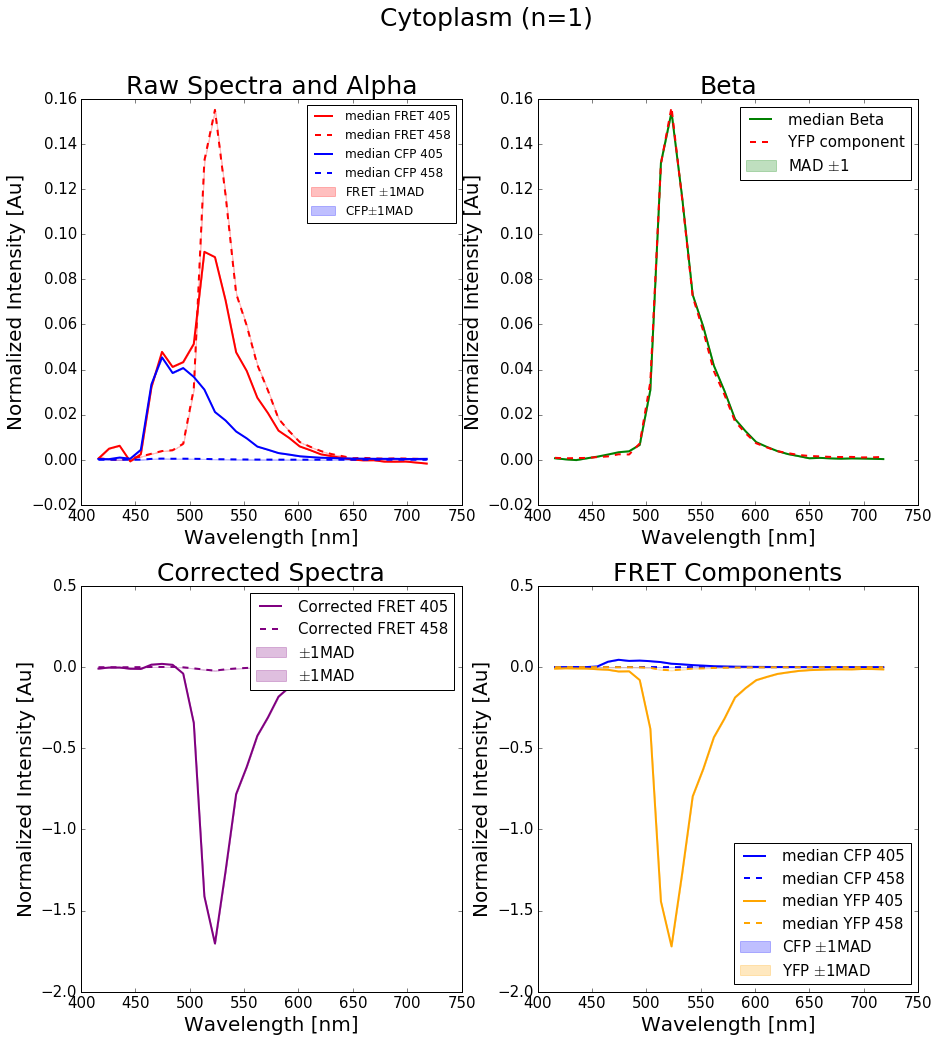

In [43]:
Data.plotFRETvariance(observation='image',plot_by='group', specify=[])


### Show Image
This function plots color coded images for any parameter calculated in the pixel observation DataFrame.

Keyword Arguments
> param=key: determines which parameter is used to form the image mapping such as Eff, D, A, I, etc.

> ex=1 or 2: determines the excitation frequency to be plotted. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> mn=float: sets the colorbar minimum

> mx=float: sets the colorbar maximum

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

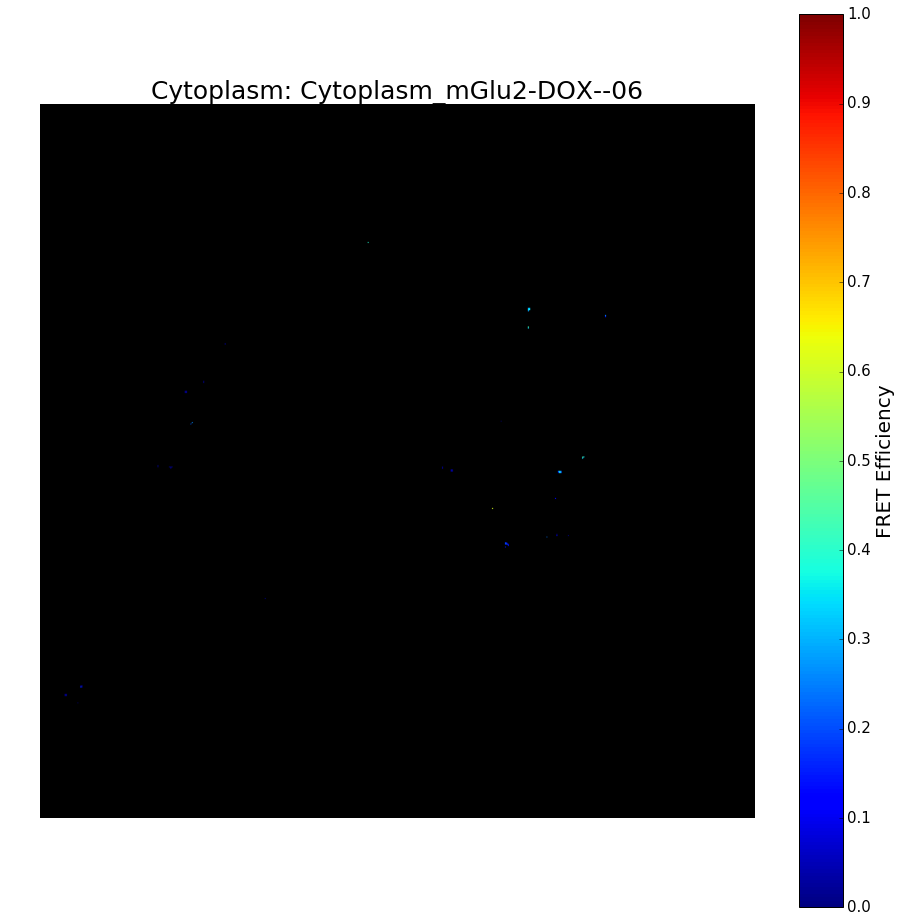

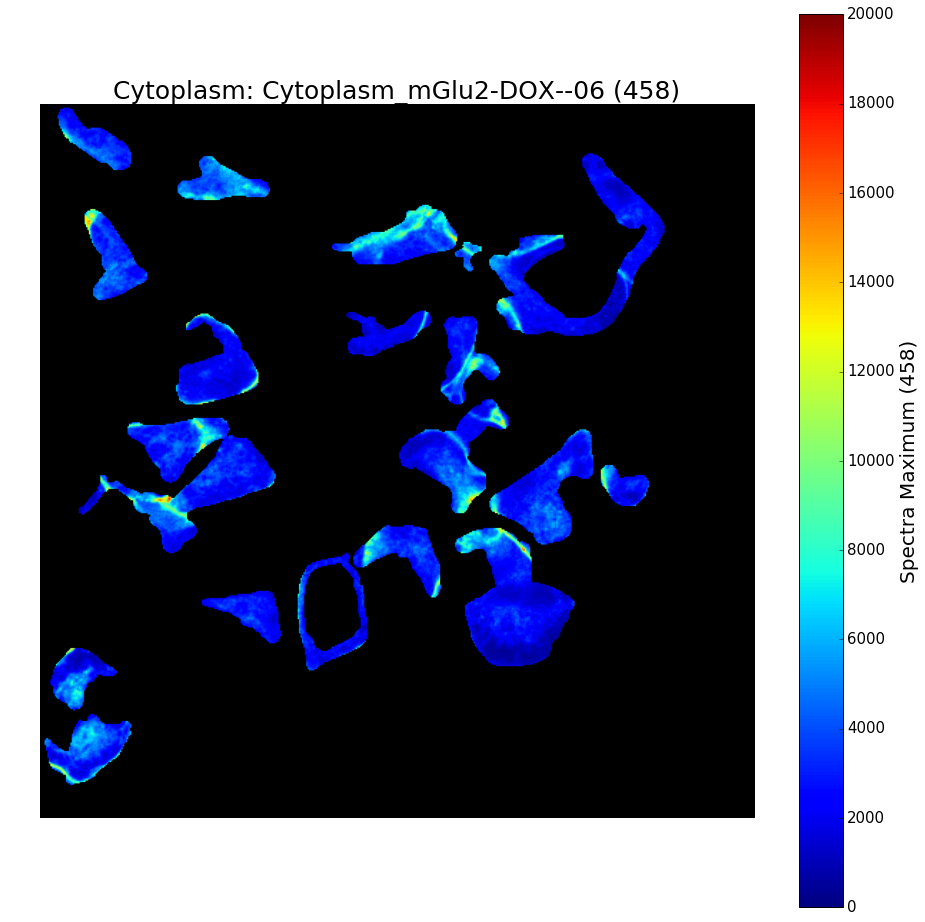

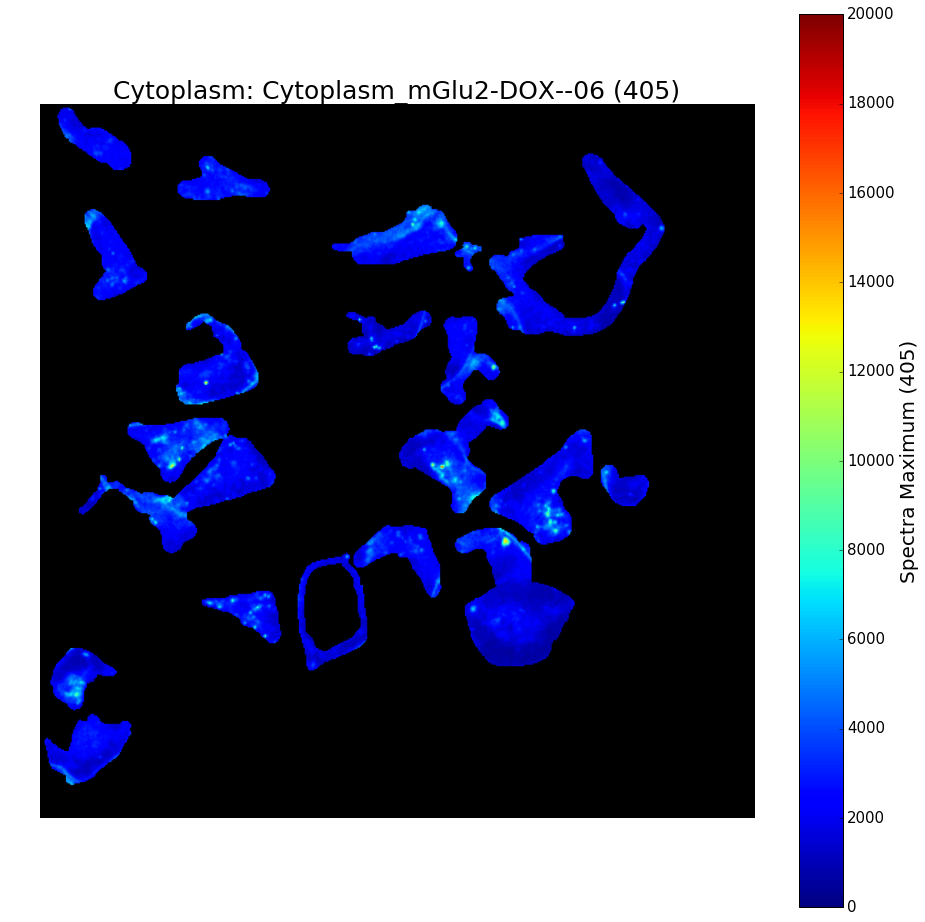

In [82]:
matplotlib.rcParams.update({'figure.figsize':(16,16)})

Data.showImage(param='Eff',ex=2,mn=0,mx=1,specify=[['D2','>',[3000]],['image','=',[0]]])
figure()
Data.showImage(param='Mx',ex=2,mn=0,mx=20000,specify=[['image','=',[0]]])
figure()
Data.showImage(param='Mx',ex=1,mn=0,mx=20000,specify=[['image','=',[0]]])
figure()

matplotlib.rcParams.update({'figure.figsize':(15,8)})

### Histogram
This function plots the full distribution of any parameter at any observation level.

Keyword Arguments
> param=key: determines which parameter is used to form the histogram such as Eff, D, A, I, etc.

> ex=1 or 2: determines the excitation frequency to be plotted. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> lim_x=[float,float]: sets the upper and lower bounds for the histogram

> bins=float: sets the number of value bands the lim_x range is divided into to form the histogram

> norm=boolean: controls whether the frequency axis of the histograms are displayed in absolute or relative observations

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

> colors=list of colors to plot with. A blank list uses the default color list.

Cytoplasm
median: 0.0847098471276
MAD: 0.232678711556


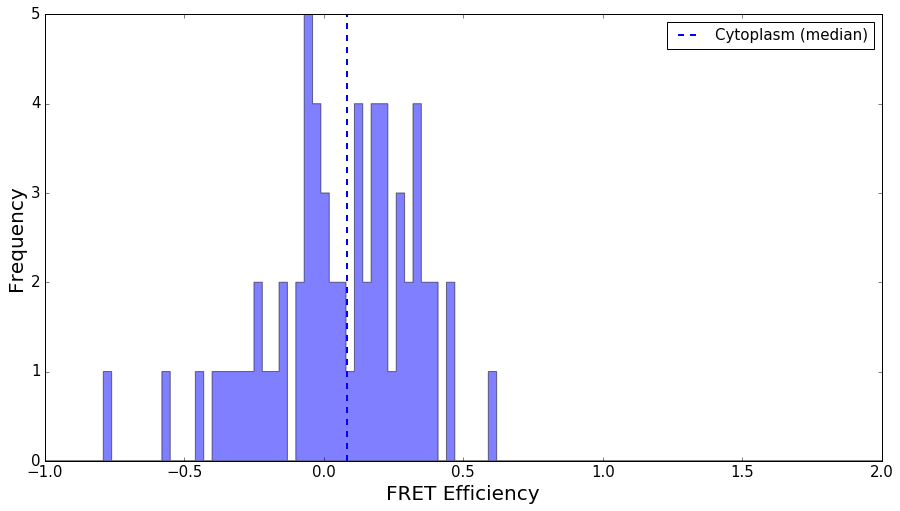

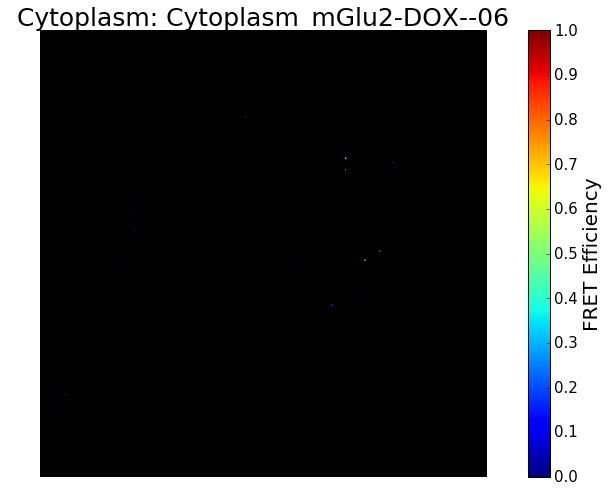

In [85]:
#Data.plotHistogram(param='Eff',ex=2,lim_x=[-.1,1.1],bins=100,norm=False,
#                      observation='group',plot_by='group',specify=[],colors=[])
#figure()
#Data.plotHistogram(param='Eff',ex=2,lim_x=[-.1,1.1],bins=30,norm=False,
#                      observation='image',plot_by='group',specify=[],colors=[])
#figure()
#Data.plotHistogram(param='Eff',ex=2,lim_x=[-.1,1.1],bins=100,norm=False,
#                      observation='region',plot_by='group',specify=[],colors=[])
#figure()
Data.plotHistogram(param='D',ex=2,lim_x=[-1,2],bins=100,norm=False,
                      observation='pixel',plot_by='group',specify=[['D2','>',[3000]]],colors=[])

Data.showImage(param='Eff',ex=2,mn=0,mx=1,specify=[['D2','>',[3000]]])

### Scatter Plot
This function generates a scatterplot of any two parameters at any observation level. The cell below displays a FRET efficiency vs Intensity scatterplot, which can help identify intermolecular FRET (as the contribution of intermolecular FRET is expected to increase with concentration, an increasing FRET with increasing intensity, ie. a significant positive slope can be indicative of this). The cell after this displays the Acceptor Direct Excitation Magnitude vs Intensity, the slope of which provides a relative measurement of the stoicheometry (higher slopes indicate more acceptor fluorophores compared to donor fluorophores)

Keyword Arguments
> param_x=key: determines which parameter is used for the X axis such as Eff, D, A, I, etc.

> ex_x=1 or 2: determines the excitation frequency to be plotted for the X axis parameter. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> lim_x=[float,float]: sets the upper and lower bounds for the X axis

> param_y=key: determines which parameter is used for the Y axis such as Eff, D, A, I, etc.

> ex_y=1 or 2: determines the excitation frequency to be plotted for the Y axis parameter. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> lim_y=[float,float]: sets the upper and lower bounds for the Y axis

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

> colors=list of colors to plot with. A blank list uses the default color list.

> alpha=float (0-1): determines the opacity of the marker dots

> fit=boolean: controls whether the data is fit using linear least squares

> print_fit=boolean: controls whether the fit parameters are displayed (slope, intercept, R^2, and P-Value)

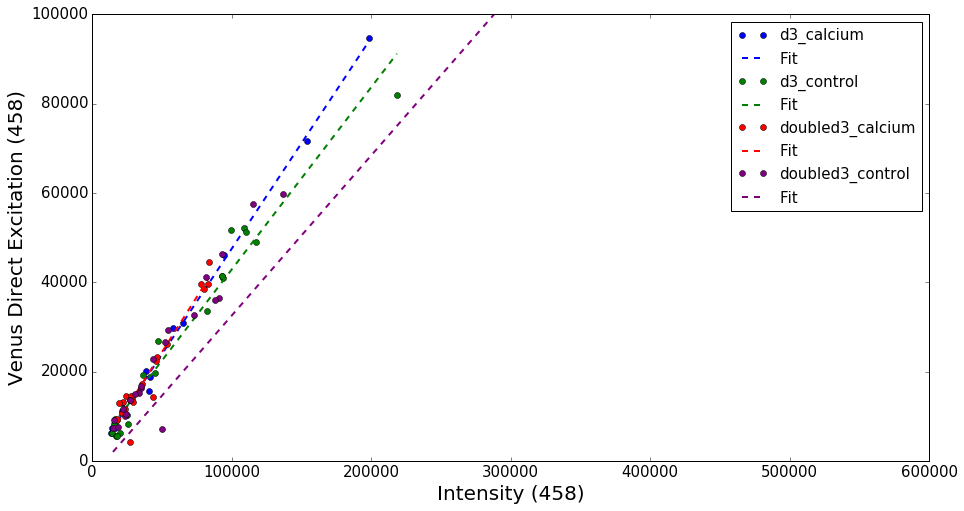

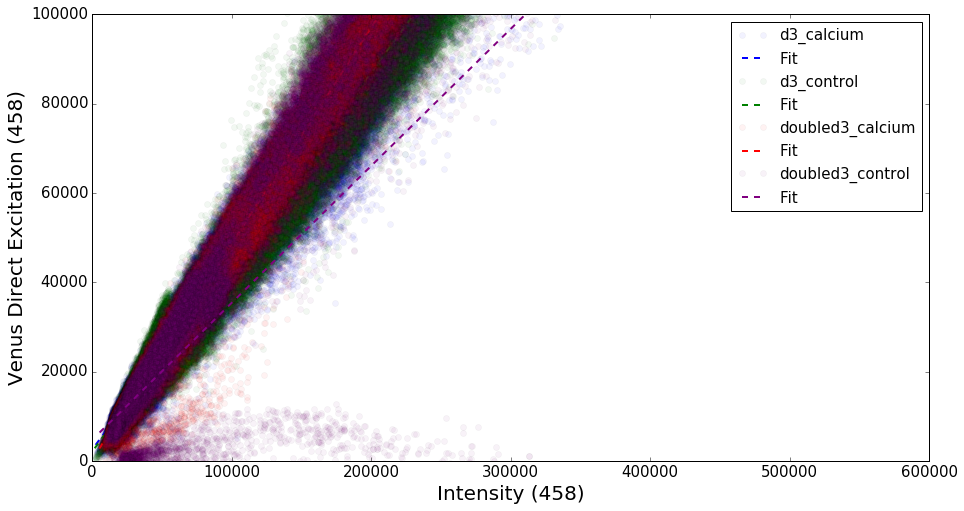

In [22]:
Data.plotScatter(param_x='I',ex_x=2,param_y='A_dir',ex_y=2,
                    lim_x=[0,6e5],lim_y=[0,1e5],observation='region',plot_by='group',
                    specify=[],colors=[],alpha=1,fit=True,print_fit=False)
figure()
Data.plotScatter(param_x='I',ex_x=2,param_y='A_dir',ex_y=2,
                    lim_x=[0,6e5],lim_y=[0,1e5],observation='pixel',plot_by='group',
                    specify=[],colors=[],alpha=.05,fit=True,print_fit=False)

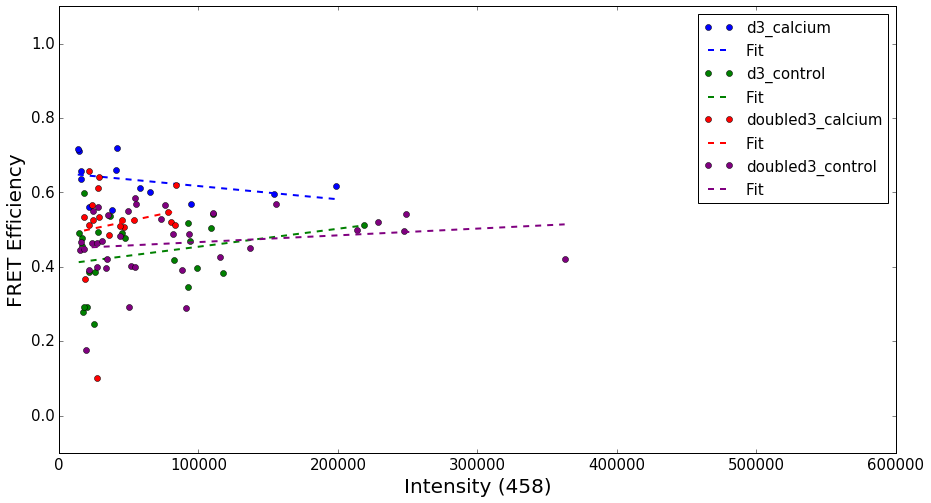

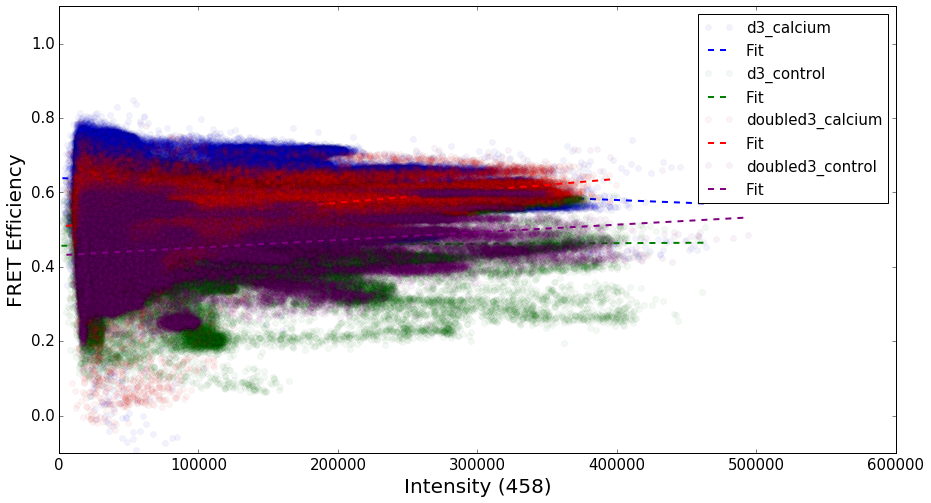

In [23]:
Data.plotScatter(param_x='I',ex_x=2,param_y='Eff',ex_y=2,
                    lim_x=[0,6e5],lim_y=[-.1,1.1],observation='region',plot_by='group',
                    specify=[],colors=[],alpha=1,fit=True,print_fit=False)
figure()
Data.plotScatter(param_x='I',ex_x=2,param_y='Eff',ex_y=2,
                    lim_x=[0,6e5],lim_y=[-.1,1.1],observation='pixel',plot_by='group',
                    specify=[],colors=[],alpha=.05,fit=True,print_fit=False)

### Boxplot
This function provides a simplified view of the distribution of any parameter allowing multiple groupings to be easily compared. The center red line denotes the median of the distribution, the shaded box region denotes the inner quartile range (IQR), the whiskers denote the last datapoint within 1.5x the IQR, and any outliers exceeding 1.5x the IQR are denoted by individual + marks.

Keyword Arguments
> param=key: determines which parameter is used to form the boxplot such as Eff, D, A, I, etc.

> ex=1 or 2: determines the excitation frequency to be plotted. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> lim_y=[float,float]: sets the upper and lower bounds for the y axis

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will have a separate plot for each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

> colors=list of colors to plot with. A blank list uses the default color list.

> rotate_labels=float: allows the labels to be rotated by the input degree value for easier viewing

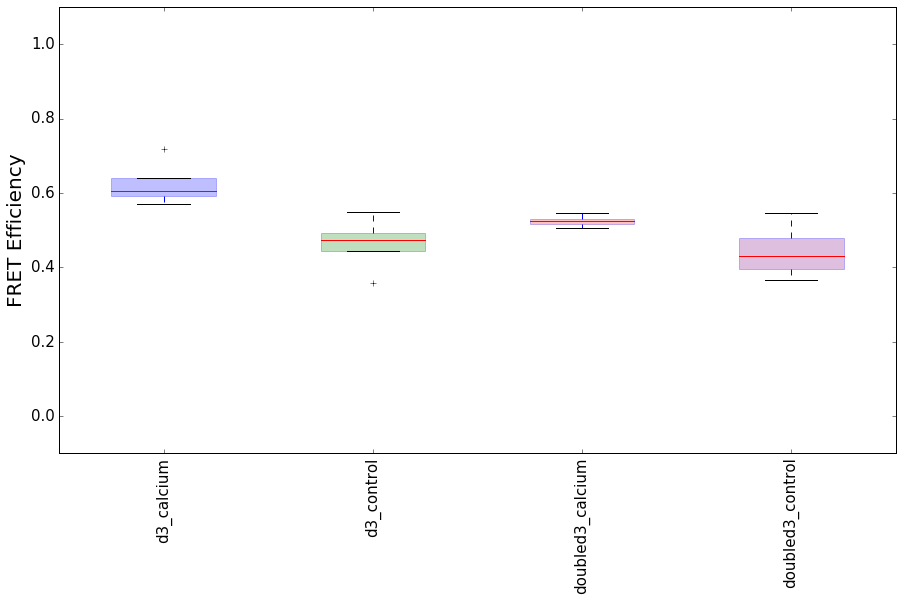

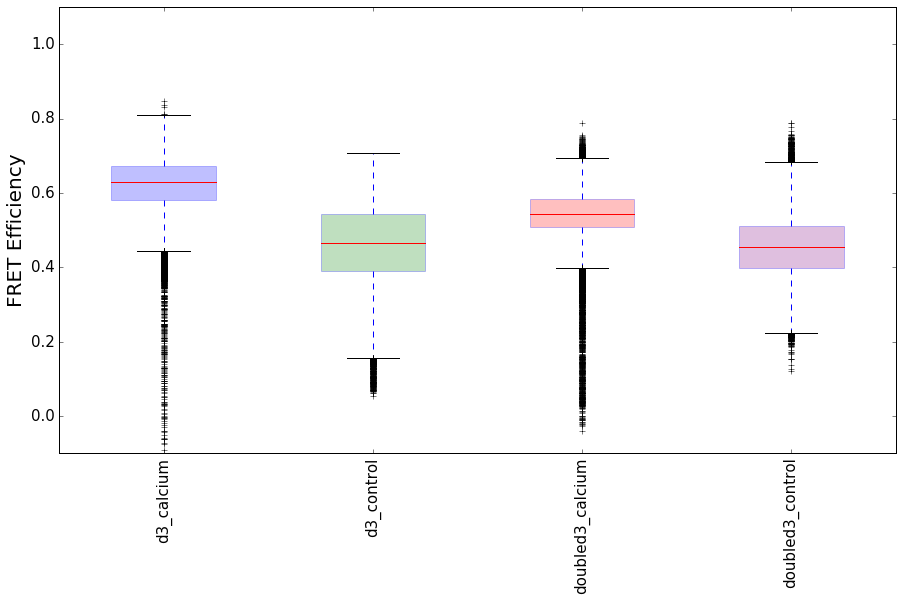

In [24]:
Data.boxplot(param='Eff',ex=2,observation='image',plot_by='group',
                lim_y=[-.1,1.1],specify=[],colors=[],rotate_labels=90)
figure()
Data.boxplot(param='Eff',ex=2,observation='pixel',plot_by='group',
                lim_y=[-.1,1.1],specify=[],colors=[],rotate_labels=90)




### Statistical Significance
This function plots a matrix comparing groupings using a statistical test of choice. Pairing considered to have statistically significant differences (P-values greater than the threshold) are denoted with black, while non significant differences are displayed in white.

Keyword Arguments
> param=key: determines which parameter is used for the statistical testing such as Eff, D, A, I, etc.

> ex=1 or 2: determines the excitation frequency to be plotted. This option is ignored for excitation independent parameters such as Eff, Alpha, Beta, etc.

> observation='pix','region','image', or 'group': allows user to change what is denoted as an single observation

> plot_by='pix','region','image', or 'group': allows user to change how many groupings are plotted 
>> eg. 'image' will perform statistical tests to compare each image

> specify=list of masks to tell which observations are included based on any parameter and simple boolean operators (=, !=, <, >, and ><). A blank list applies no mask
>> eg. specify=[['image','=',[0,1]],['I2','>',[10000]]] will only include spectra from images 0 and 1 with intensities at frequency 2 greater than 10000

> colors=list of colors to plot with. A blank list uses the default color list.

> threshold=float: sets the P-value which is considered statistically significant

> test= "One Way ANOVA","Mann-Whitney U Test","T-Test",or "Kruskal-Wallis Test": allows user to specify which type of statistical test is to be used 
>> Mann-Whitney U Test is based on the median and therefore more appropriate for comparing Cauchy distributed parameters such as the FRET efficiency

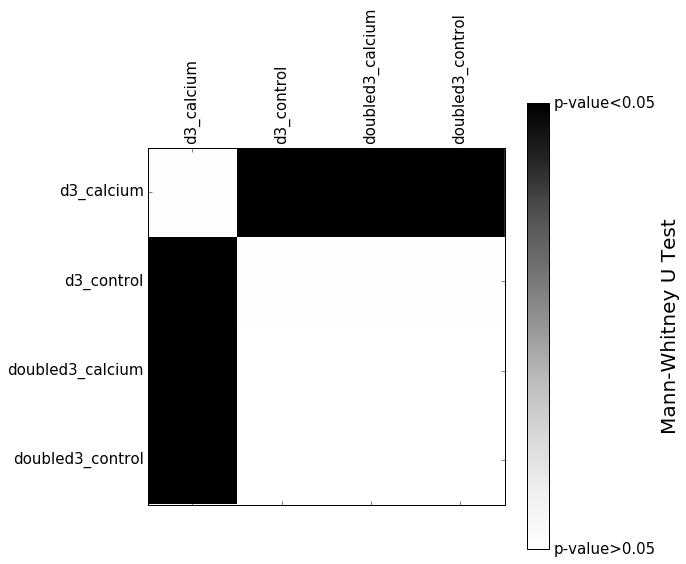

In [25]:
Data.significance(param='Eff',ex=2,observation='image',plot_by='group',
                threshold=.05,test="Mann-Whitney U Test",print_pval=False,specify=[],colors=[])

### Export .xlsx file
This function saves the DataFrame variable for each observation type (group, image, region and pixel) as a page in an excel sheet along with the experiment options chosen to analyze the data (central tendency method, calibration data, etc.) As a default, individual pixel observations are not saved because exporting more than ~20,000 pixels begins to take a significant amount of time but this can be overridden by adding pix to the observation list.

Keyword Arguments:
> observation=list: lists the names of each observation type to be saved into the excel file ('group', 'image', 'region', and 'pixel')

In [26]:
Data.export_xlsx(observation=Export_Data)

# Export .html file
The code in the following cell is based on Mac OSX commands and may need to be adjusted to work in Windows (mv=move in windows, etc)

In [27]:
export_command='jupyter nbconvert --to html pySensor.ipynb'
rename_command='mv pySensor.html Data_Archive/'+Data.ExpName+'.html'
os.system(export_command)
os.system(rename_command)



0